In [1]:
# import all required packages
import time
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
plt.style.use('ggplot')

import networkx as nx
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

import dgl
import dgl.nn as dglnn

import torch
import torch.nn as nn
import torch.nn.functional as F
from sage import SAGEConv

import tqdm

import sklearn.metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

Using backend: pytorch


In [2]:
# used for scaling non-ordinal data within the range of 1 - 5 
def normalize(x):
    return (x-x.min())/(x.max()-x.min()) * (5-1) + 1

In [3]:
# l2 normalization of GNN layer outputs after activation function
def norm(x):
    return F.normalize(x, p=2, dim=-1)

Norm = norm

In [4]:
df = pd.read_csv('DataFrame')
X = pd.read_csv('clean_data')

In [5]:
df['Type of Travel'].value_counts(normalize=True)

Business travel    0.689167
Personal Travel    0.310833
Name: Type of Travel, dtype: float64

In [6]:
X.drop(columns=['Unnamed: 0'],inplace=True)
X.Class = X.Class.apply(lambda x: 1 if x == 0 else(2 if x == 1 else 3))
X

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,satisfaction
0,1,0,69,0,1,964,3,2,3,3,...,2,5,5,3,5,1,5,3,0,0
1,0,0,55,1,3,240,2,5,5,5,...,2,1,1,2,3,2,3,2,163,0
2,1,0,51,1,3,2672,5,5,5,5,...,1,4,4,4,4,5,4,3,0,1
3,0,1,27,1,1,495,2,3,2,2,...,3,3,4,4,3,4,2,3,0,0
4,0,0,12,0,1,462,2,4,2,3,...,2,2,3,4,2,2,1,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,1,0,49,0,1,1587,3,4,3,4,...,5,4,4,3,5,3,4,5,35,0
5996,1,0,33,0,1,588,2,5,2,3,...,5,5,5,3,5,5,5,5,0,0
5997,0,0,50,0,1,2358,1,4,1,5,...,4,4,4,5,4,4,3,4,0,0
5998,0,0,35,0,1,672,2,3,2,2,...,5,5,1,1,4,4,1,5,0,0


In [7]:
bus = (X['Type of Travel'] == 1)
pers = (X['Type of Travel'] == 0)
X[pers]['Gate location'].value_counts()

3    665
4    460
2    339
1    277
5    124
Name: Gate location, dtype: int64

In [8]:
X[bus]['satisfaction'].describe()

count    4135.000000
mean        0.578718
std         0.493824
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: satisfaction, dtype: float64

In [9]:
A = np.loadtxt('adjacency_matrix.csv',delimiter=',')

In [10]:
np.diag(A).sum()

0.0

In [11]:
G = nx.from_numpy_matrix(A)

In [12]:
nx.is_connected(G)

True

In [13]:
features = pd.Series(X.satisfaction) 

In [14]:
x_var = X.drop(columns=['satisfaction'])
x_wd = pd.get_dummies(data=x_var,columns=['Customer Type','Type of Travel','Gender'])
x_wd[['Age','Departure Delay in Minutes','Flight Distance']] = normalize(x_wd[['Age','Departure Delay in Minutes','Flight Distance']])

In [15]:
# Load Test Data
df_test = pd.read_csv('test.csv',sep=',')
df_test = df_test.sample(n=6000)
df_test.drop(columns=['Unnamed: 0','id'],inplace=True)
df_test.Gender = df_test.Gender.apply(lambda x: 0 if x == 'Male' else 1)
df_test['Customer Type'] = df_test['Customer Type'].apply(lambda x: 0 if x == 'Loyal Customer' else 1)
df_test['Type of Travel'] = df_test['Type of Travel'].apply(lambda x: 0 if x == 'Personal Travel' else 1)
df_test['Class'] = df_test['Class'].apply(lambda x: 0 if x == 'Eco' else(1 if x == 'Eco Plus' else 2))
df_test['satisfaction'] = df_test['satisfaction'].apply(lambda x: 0 if x == 'neutral or dissatisfied' else 1)
df_test.reset_index(drop=True,inplace=True)
df_test.drop(columns=['Arrival Delay in Minutes'],inplace = True)

In [16]:
TEST = df_test.copy(deep=True)

In [17]:
test_gen = TEST[['Gender','Customer Type','Age','Type of Travel','Class']].copy(deep=True)
test_gen.Age = test_gen.Age.apply(lambda x: 0 if x < 26 else(1 if x < 39 else(2 if x < 50 else 3)))

In [18]:
TEST.Class = TEST.Class.apply(lambda x: 1 if x == 0 else(2 if x == 1 else 3))

In [19]:
xx = TEST.drop(columns=['satisfaction'])
xx_dummy = pd.get_dummies(data=xx,columns=['Customer Type','Type of Travel','Gender'])
xx_dummy[['Age','Departure Delay in Minutes','Flight Distance']] = normalize(xx_dummy[['Age','Departure Delay in Minutes','Flight Distance']])
yy = TEST.satisfaction

In [20]:
pos = nx.spring_layout(G)

In [21]:
dissatisfied = df.index[df.satisfaction == 'neutral or dissatisfied'].tolist()
satisfied = df.index[df.satisfaction == 'satisfied'].tolist()

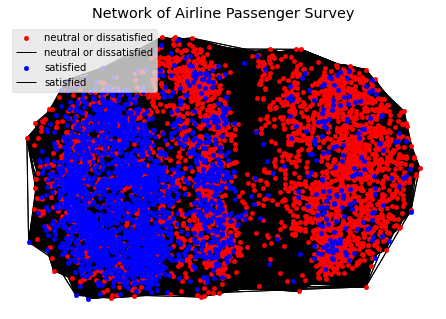

In [22]:
nx.draw(G,pos,nodelist=dissatisfied,node_size=20,node_color='r',label='neutral or dissatisfied')
nx.draw(G,pos,nodelist=satisfied,node_size=20,node_color='b',label='satisfied')
plt.title('Network of Airline Passenger Survey')
plt.legend()
plt.show()

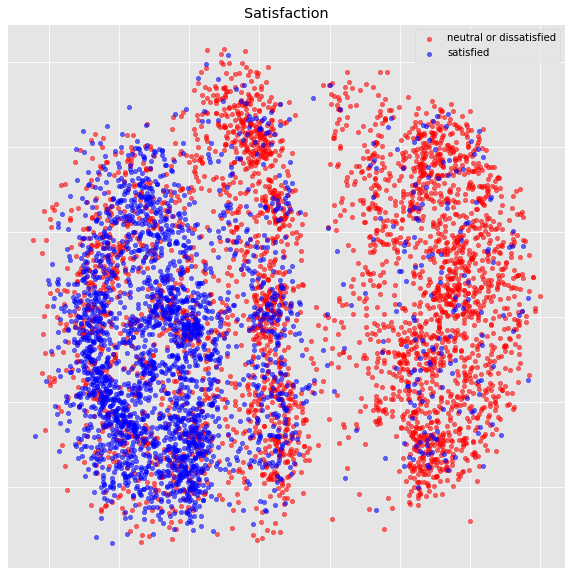

In [23]:
plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(G,pos,nodelist=dissatisfied,node_size=20,node_color='r', alpha=0.6,label='neutral or dissatisfied')
nx.draw_networkx_nodes(G,pos,nodelist=satisfied,node_size=20,node_color='b', alpha=0.6,label='satisfied')
plt.legend()
plt.title('Satisfaction')
plt.show()

<AxesSubplot:>

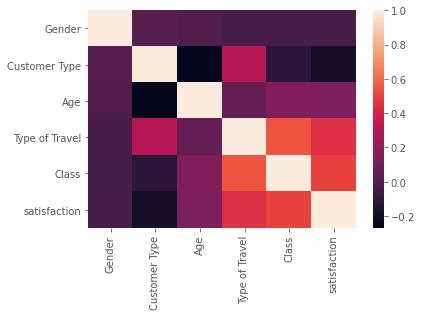

In [24]:
cormap_vars = X[['Gender','Customer Type','Age','Type of Travel','Class','satisfaction']]
cormap = cormap_vars.corr()
sns.heatmap(cormap)

In [25]:
male = df.index[df.Gender == 'Male'].tolist()
female = df.index[df.Gender == 'Female'].tolist()

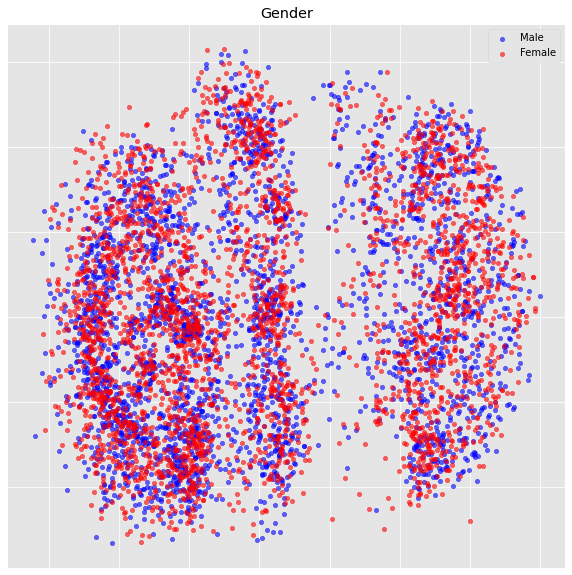

In [26]:
plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(G,pos,nodelist=male,node_size=20,node_color='b', alpha=0.6,label='Male')
nx.draw_networkx_nodes(G,pos,nodelist=female,node_size=20,node_color='r', alpha=0.6,label='Female')
plt.legend()
plt.title('Gender')
plt.show()

In [27]:
loyal = df.index[df['Customer Type'] == 'Loyal Customer'].tolist()
disloyal = df.index[df['Customer Type'] == 'disloyal Customer'].tolist()

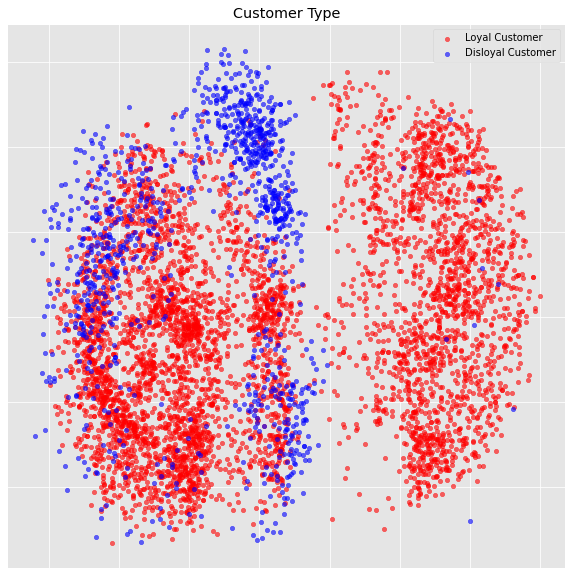

In [28]:
plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(G,pos,nodelist=loyal,node_size=20,node_color='r', alpha=0.6,label='Loyal Customer')
nx.draw_networkx_nodes(G,pos,nodelist=disloyal,node_size=20,node_color='b', alpha=0.6,label='Disloyal Customer')
plt.legend()
plt.title('Customer Type')
plt.show()

In [29]:
eco = df.index[df.Class == 'Eco'].tolist()
eco_plus = df.index[df.Class == 'Eco Plus'].tolist()
bus = df.index[df.Class == 'Business'].tolist()

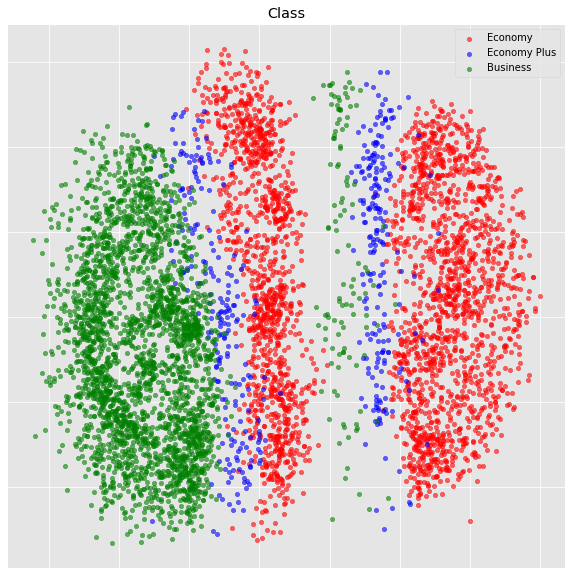

In [30]:
plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(G,pos,nodelist=eco,node_size=20,node_color='r', alpha=0.6,label='Economy')
nx.draw_networkx_nodes(G,pos,nodelist=eco_plus,node_size=20,node_color='b', alpha=0.6,label='Economy Plus')
nx.draw_networkx_nodes(G,pos,nodelist=bus,node_size=20,node_color='g', alpha=0.6,label='Business')
plt.legend()
plt.title('Class')
plt.show()

In [31]:
personal = df.index[df['Type of Travel'] == 'Personal Travel'].tolist()
business = df.index[df['Type of Travel'] == 'Business travel'].tolist()

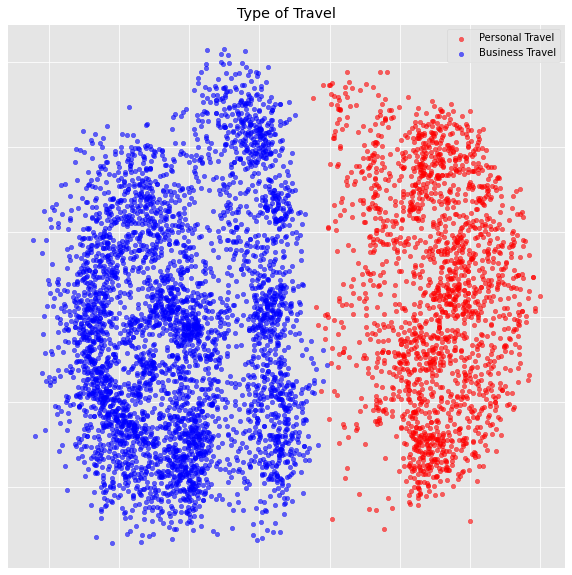

In [32]:
plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(G,pos,nodelist=personal,node_size=20,node_color='r', alpha=0.6,label='Personal Travel')
nx.draw_networkx_nodes(G,pos,nodelist=business,node_size=20,node_color='b', alpha=0.6,label = 'Business Travel')
plt.legend()
plt.title('Type of Travel')
plt.show()

In [33]:
AGE = df.Age.apply(lambda x: 0 if x < 26 else(1 if x < 39 else(2 if x < 50 else 3)))

In [34]:
age0 = AGE.index[AGE == 0].tolist()
age1 = AGE.index[AGE == 1].tolist()
age2 = AGE.index[AGE == 2].tolist()
age3 = AGE.index[AGE == 3].tolist()

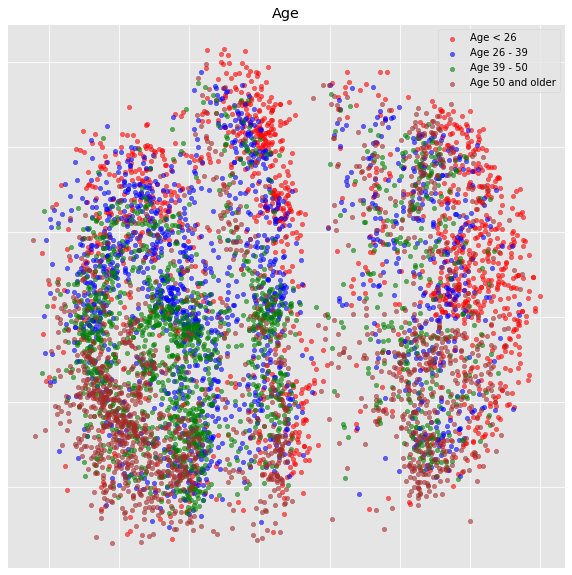

In [35]:
plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(G,pos,nodelist=age0,node_size=20,node_color='r', alpha=0.6,label = 'Age < 26')
nx.draw_networkx_nodes(G,pos,nodelist=age1,node_size=20,node_color='b', alpha=0.6,label = 'Age 26 - 39')
nx.draw_networkx_nodes(G,pos,nodelist=age2,node_size=20,node_color='g', alpha=0.6,label = 'Age 39 - 50')
nx.draw_networkx_nodes(G,pos,nodelist=age3,node_size=20,node_color='brown', alpha=0.6,label = 'Age 50 and older' )
plt.legend()
plt.title('Age')
plt.show()

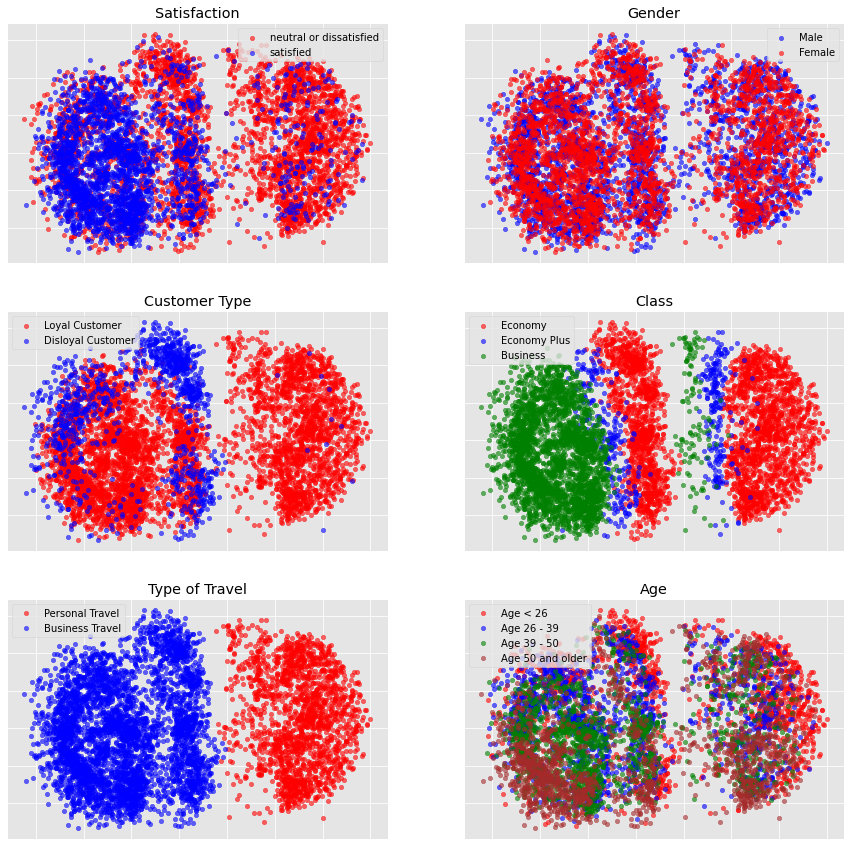

In [36]:
fig = plt.subplots(figsize=(15,15))

plt.subplot(321)
nx.draw_networkx_nodes(G,pos,nodelist=dissatisfied,node_size=20,node_color='r', alpha=0.6,label='neutral or dissatisfied')
nx.draw_networkx_nodes(G,pos,nodelist=satisfied,node_size=20,node_color='b', alpha=0.6,label='satisfied')
plt.title('Satisfaction')
plt.legend()

plt.subplot(322)
nx.draw_networkx_nodes(G,pos,nodelist=male,node_size=20,node_color='b', alpha=0.6,label='Male')
nx.draw_networkx_nodes(G,pos,nodelist=female,node_size=20,node_color='r', alpha=0.6,label='Female')
plt.title('Gender')
plt.legend()

plt.subplot(323)
nx.draw_networkx_nodes(G,pos,nodelist=loyal,node_size=20,node_color='r', alpha=0.6,label='Loyal Customer')
nx.draw_networkx_nodes(G,pos,nodelist=disloyal,node_size=20,node_color='b', alpha=0.6,label='Disloyal Customer')
plt.title('Customer Type')
plt.legend()

plt.subplot(324)
nx.draw_networkx_nodes(G,pos,nodelist=eco,node_size=20,node_color='r', alpha=0.6,label='Economy')
nx.draw_networkx_nodes(G,pos,nodelist=eco_plus,node_size=20,node_color='b', alpha=0.6,label='Economy Plus')
nx.draw_networkx_nodes(G,pos,nodelist=bus,node_size=20,node_color='g', alpha=0.6,label='Business')
plt.title('Class')
plt.legend()

plt.subplot(325)
nx.draw_networkx_nodes(G,pos,nodelist=personal,node_size=20,node_color='r', alpha=0.6,label='Personal Travel')
nx.draw_networkx_nodes(G,pos,nodelist=business,node_size=20,node_color='b', alpha=0.6,label = 'Business Travel')
plt.title('Type of Travel')
plt.legend()

plt.subplot(326)
nx.draw_networkx_nodes(G,pos,nodelist=age0,node_size=20,node_color='r', alpha=0.6,label = 'Age < 26')
nx.draw_networkx_nodes(G,pos,nodelist=age1,node_size=20,node_color='b', alpha=0.6,label = 'Age 26 - 39')
nx.draw_networkx_nodes(G,pos,nodelist=age2,node_size=20,node_color='g', alpha=0.6,label = 'Age 39 - 50')
nx.draw_networkx_nodes(G,pos,nodelist=age3,node_size=20,node_color='brown', alpha=0.6,label = 'Age 50 and older')
plt.title('Age')
plt.legend()

plt.show()


In [37]:
G_dgl = dgl.from_networkx(G)

G_dgl.ndata['feat'] =  torch.tensor(x_wd.values,dtype=torch.float)
G_dgl.ndata['train_mask'] = torch.zeros(len(G_dgl.nodes()), dtype=torch.bool).bernoulli(0.8)
G_dgl.ndata['label'] = torch.tensor(features)

In [38]:
G_dgl.ndata['val_mask'] = torch.empty(len(G_dgl.nodes()))
for i in range(len(G_dgl.ndata['train_mask'])):
    if G_dgl.ndata['train_mask'][i] == True:
        G_dgl.ndata['val_mask'][i] = False
    else:
        G_dgl.ndata['val_mask'][i] = True

G_dgl.ndata['val_mask'] = G_dgl.ndata['val_mask'].type(torch.bool)

In [ ]:
node_features = G_dgl.ndata['feat']
node_labels = G_dgl.ndata['label']
train_mask = G_dgl.ndata['train_mask']
valid_mask = G_dgl.ndata['val_mask']
n_features = node_features.shape[1]
n_labels = int(node_labels.max().item() + 1)

In [ ]:
train_nodes = (train_mask == True).nonzero(as_tuple=False)
train_nids = torch.reshape(train_nodes,(-1,))
valid_nodes = (valid_mask == True).nonzero(as_tuple=False)
valid_nids = torch.reshape(valid_nodes,(-1,))

In [ ]:
len(train_nids)

In [ ]:
len(valid_nids)

In [ ]:
batch_size = 50
sampler = dgl.dataloading.MultiLayerNeighborSampler([5,10])
train_dataloader = dgl.dataloading.NodeDataLoader(
    G_dgl, train_nids, sampler,
    batch_size=batch_size,
    shuffle=True,
    drop_last=False,
    num_workers=0
)

In [ ]:
example_minibatch = next(iter(train_dataloader))
print(example_minibatch)

In [ ]:
input_nodes, output_nodes, bipartites = example_minibatch
print("To compute {} nodes' output we need {} nodes' input features".format(len(output_nodes), len(input_nodes)))

In [ ]:
print(bipartites)

In [ ]:
batch_size = len(valid_nids)
valid_dataloader = dgl.dataloading.NodeDataLoader(
    G_dgl, valid_nids, sampler,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=0
)

In [ ]:
class SAGE(nn.Module):
    def __init__(self, in_feats, n_hidden, n_classes, n_layers,agg_type='pool'):
        super().__init__()
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.n_classes = n_classes
        self.layers = nn.ModuleList()
        self.layers.append(dglnn.SAGEConv(in_feats, n_hidden, aggregator_type=agg_type, bias=True, feat_drop=0.02,norm=Norm,activation=nn.ReLU(inplace=False)))
        for i in range(1, n_layers - 1):
            self.layers.append(dglnn.SAGEConv(n_hidden, n_hidden, aggregator_type=agg_type, bias=True, feat_drop=0.02,norm=Norm,activation=nn.ReLU(inplace=False)))
        self.layers.append(dglnn.SAGEConv(n_hidden, n_classes, aggregator_type=agg_type, bias=True, feat_drop=0.02,norm=None,activation=None))
        
    def forward(self, bipartites, x):
        for l, (layer, bipartite) in enumerate(zip(self.layers, bipartites)):
            x = layer(bipartite, x)
        return x

In [ ]:
## Used for sum-pooling
class SumSAGE(nn.Module):
    def __init__(self, in_feats, n_hidden, n_classes, n_layers):
        super().__init__()
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.n_classes = n_classes
        self.layers = nn.ModuleList()
        self.layers.append(SAGEConv(in_feats, n_hidden, aggregator_type='pool', bias=True, feat_drop=0.02,norm=Norm,activation=nn.ReLU(inplace=False)))
        for i in range(1, n_layers - 1):
            self.layers.append(SAGEConv(n_hidden, n_hidden, aggregator_type='pool', bias=True, feat_drop=0.02,norm=Norm,activation=nn.ReLU(inplace=False)))
        self.layers.append(SAGEConv(n_hidden, n_classes, aggregator_type='pool', bias=True, feat_drop=0.02,norm=None,activation=None))
        
    def forward(self, bipartites, x):
        for l, (layer, bipartite) in enumerate(zip(self.layers, bipartites)):
            x = layer(bipartite, x)
            
        return x

In [ ]:
#model = SumSAGE(n_features, len(x_wd.T), n_labels, 2) #n_layers
model = SAGE(n_features, len(x_wd.T), n_labels, 2, agg_type='mean') #n_layers
opt = torch.optim.Adam(model.parameters(),lr=0.002)# GraphSage

In [ ]:
# GraphSage
best_accuracy = 0
best_model_path = 'model.pt'
epoch_losses_train = []
plot_loss_valid = []
train_acc = []
valid_acc = []
dur = []

for epoch in range(400):
    t0 = time.time()
    model.train()
    loss_epoch = 0
    accuracy_epoch = 0
    for step, (input_nodes, output_nodes, bipartites) in enumerate(train_dataloader):
        inputs = node_features[input_nodes]
        labels = node_labels[output_nodes]
        logits = model(bipartites, inputs)
        predictions = F.log_softmax(logits,dim=1)

        loss = F.cross_entropy(logits, labels)
        loss_epoch += loss.detach().item()
        opt.zero_grad()
        loss.backward()
        opt.step()

        accuracy = accuracy_score(labels.numpy(), predictions.argmax(1).detach().numpy())
        accuracy_epoch += accuracy
    accuracy_epoch /= (step + 1)
    loss_epoch /= (step + 1)
    epoch_losses_train.append(loss_epoch)
    train_acc.append(accuracy_epoch)
    print('Epoch: {}, Training Accuracy: {:.3f}, Training Loss: {:.3f}'.format(epoch, accuracy_epoch, loss_epoch))
        
    model.eval()
    
    predictions = []
    labels = []
    with torch.no_grad():
        for input_nodes, output_nodes, bipartites in valid_dataloader:
            inputs = node_features[input_nodes]
            labels.append(node_labels[output_nodes].numpy())
            predictions.append(F.log_softmax(model(bipartites, inputs),dim=1).argmax(1).numpy())
            valid_logits = model(bipartites, inputs)
            valid_labels = node_labels[output_nodes]
            valid_loss = F.cross_entropy(valid_logits, valid_labels)

        predictions = np.concatenate(predictions)
        labels = np.concatenate(labels)
        
        accuracy = accuracy_score(labels, predictions)
        dur.append(time.time() - t0)
        print('Epoch: {}, Validation Accuracy: {:.3f}, Validation Loss: {:.3f}, Time: {:.4f}'.format(epoch, accuracy, valid_loss.item(), np.mean(dur)))
        valid_acc.append(accuracy.item())
        plot_loss_valid.append(valid_loss.item())
    
torch.save(model.state_dict(), best_model_path)


In [ ]:
plt.figure(figsize=(10,10))
plt.plot(epoch_losses_train, label='Training Loss')
plt.plot(plot_loss_valid, label='Validation Loss')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(valid_acc, label='Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
print('Training Accuracy: {}'.format(train_acc[-1]))
print('Validation Accuracy: {}'.format(valid_acc[-1]))

In [ ]:
np.argmax(valid_acc)

In [ ]:
plt.subplots(figsize=(15,5))

plt.subplot(121)
plt.plot(epoch_losses_train, label='Training Loss')
plt.plot(plot_loss_valid, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend()

plt.subplot(122)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(valid_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
model.parameters

In [58]:
G_dgl.ndata['feat'] =  torch.tensor(x_wd.values,dtype=torch.float)
G_dgl.ndata['train_mask'] = torch.zeros(len(G_dgl.nodes()), dtype=torch.bool).bernoulli(0.3)
G_dgl.ndata['label'] = torch.tensor(features)

G_dgl.ndata['val_mask'] = torch.empty(len(G_dgl.nodes()))
for i in range(len(G_dgl.ndata['train_mask'])):
    if G_dgl.ndata['train_mask'][i] == True:
        G_dgl.ndata['val_mask'][i] = False
    else:
        G_dgl.ndata['val_mask'][i] = True

G_dgl.ndata['val_mask'] = G_dgl.ndata['val_mask'].type(torch.bool)

node_features = G_dgl.ndata['feat']
node_labels = G_dgl.ndata['label']
train_mask = G_dgl.ndata['train_mask']
valid_mask = G_dgl.ndata['val_mask']
n_features = node_features.shape[1]
n_labels = int(node_labels.max().item() + 1)

In [59]:
class GCN(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats):
        super().__init__()
        self.conv1 = dglnn.pytorch.conv.GraphConv(
            in_feats=in_feats, out_feats=hid_feats,norm='both', weight=True, bias=True, activation=nn.ReLU(inplace=False))
        
        self.conv2 = dglnn.pytorch.conv.GraphConv(
            in_feats=hid_feats, out_feats=out_feats,norm='both', weight=True, bias=True, activation=nn.LogSoftmax(dim=1))
        
    def forward(self, graph, inputs):
        h = self.conv1(graph, inputs)
        h = self.conv2(graph, h)
        return h

In [60]:
model_gcn = GCN(n_features, len(x_wd.T) , n_labels) # 
opt = torch.optim.Adam(model_gcn.parameters(),lr=0.002)#GCN

In [61]:
def evaluate(model_gcn, graph, features, labels, mask):
    model.eval()
    with torch.no_grad():
        logits = model_gcn(graph, features)
        logits = logits[mask]
        labels = labels[mask]
        preds = F.log_softmax(logits,dim=1)
        _, indices = torch.max(preds, dim=1)
        correct = torch.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)

In [62]:
#model = GCN(in_feats=n_features, hid_feats_1=128, hid_feats_2=128, out_feats=n_labels)
#opt = torch.optim.Adam(model.parameters(),lr=1e-2)
plot_loss_train = []
plot_loss_val = []
valid_acc = []
train_acc = []
dur = []
for epoch in range(1000):
    t0 = time.time()
    model_gcn.train()
    # forward propagation by using all nodes
    logits = model_gcn(G_dgl, node_features)
    # compute loss
    loss_train = F.cross_entropy(logits[train_mask], node_labels[train_mask])
    acc_train = evaluate(model_gcn, G_dgl, node_features, node_labels, train_mask)
    train_acc.append(acc_train)
    plot_loss_train.append(loss_train.item())
    opt.zero_grad()
    loss_train.backward()
    opt.step()
    
    model.eval()
    
    # compute validation accuracy
    with torch.no_grad():
        acc_val = evaluate(model_gcn, G_dgl, node_features, node_labels, valid_mask)
        loss_val = F.cross_entropy(logits[valid_mask], node_labels[valid_mask])
        valid_acc.append(acc_val)
        plot_loss_val.append(loss_val.item())
    # backward propagation
    
    dur.append(time.time() - t0)
    if epoch % 10 == 0:
        print('Epoch: {}, train loss: {:.4f}, validation loss: {:.4f}, training accuracy: {:.4f}, validation accuracy: {:.4f}, Time: {:.4f}'.format(epoch,loss_train.item(),loss_val.item(),acc_train,acc_val,np.mean(dur)))


Epoch: 0, train loss: 4.0951, validation loss: 4.0998, training accuracy: 0.4310, validation accuracy: 0.4288, Time: 0.4243
Epoch: 10, train loss: 0.8660, validation loss: 0.8666, training accuracy: 0.4310, validation accuracy: 0.4288, Time: 0.4583
Epoch: 20, train loss: 0.9500, validation loss: 0.9444, training accuracy: 0.5690, validation accuracy: 0.5712, Time: 0.4290
Epoch: 30, train loss: 0.6742, validation loss: 0.6727, training accuracy: 0.6544, validation accuracy: 0.4288, Time: 0.4167
Epoch: 40, train loss: 0.6828, validation loss: 0.6811, training accuracy: 0.4534, validation accuracy: 0.6569, Time: 0.4450
Epoch: 50, train loss: 0.6734, validation loss: 0.6701, training accuracy: 0.5690, validation accuracy: 0.5712, Time: 0.4165
Epoch: 60, train loss: 0.6581, validation loss: 0.6553, training accuracy: 0.7605, validation accuracy: 0.7610, Time: 0.4088
Epoch: 70, train loss: 0.6532, validation loss: 0.6498, training accuracy: 0.6119, validation accuracy: 0.5712, Time: 0.4154
E

Epoch: 660, train loss: 0.5377, validation loss: 0.5169, training accuracy: 0.7655, validation accuracy: 0.7641, Time: 0.3460
Epoch: 670, train loss: 0.5373, validation loss: 0.5164, training accuracy: 0.7655, validation accuracy: 0.7641, Time: 0.3452
Epoch: 680, train loss: 0.5368, validation loss: 0.5159, training accuracy: 0.7661, validation accuracy: 0.7648, Time: 0.3444
Epoch: 690, train loss: 0.5363, validation loss: 0.5154, training accuracy: 0.7661, validation accuracy: 0.7650, Time: 0.3440
Epoch: 700, train loss: 0.5359, validation loss: 0.5149, training accuracy: 0.7661, validation accuracy: 0.7650, Time: 0.3434
Epoch: 710, train loss: 0.5354, validation loss: 0.5145, training accuracy: 0.7661, validation accuracy: 0.7655, Time: 0.3432
Epoch: 720, train loss: 0.5350, validation loss: 0.5140, training accuracy: 0.7666, validation accuracy: 0.7657, Time: 0.3425
Epoch: 730, train loss: 0.5345, validation loss: 0.5135, training accuracy: 0.7666, validation accuracy: 0.7657, Time:

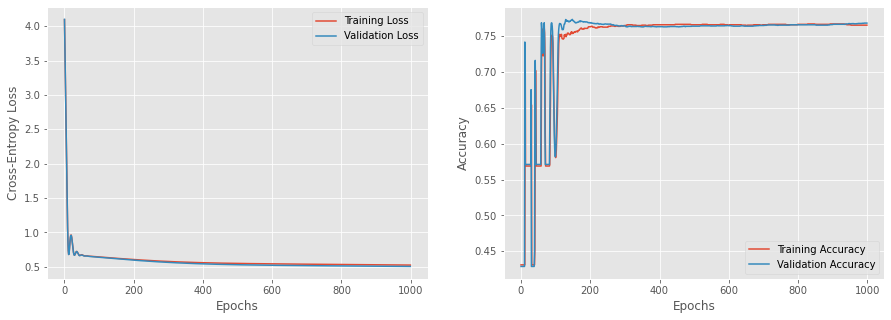

In [63]:
plt.subplots(figsize=(15,5))

plt.subplot(121)
plt.plot(plot_loss_train,label='Training Loss')
plt.plot(plot_loss_val,label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend()

plt.subplot(122)
plt.plot(train_acc,label='Training Accuracy')
plt.plot(valid_acc,label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [64]:
val_tens = torch.tensor(features)
_, indices_val = torch.max(logits[valid_mask], dim=1)
val_lab = val_tens[valid_mask]
train_lab = val_tens[train_mask]
_, indices_train = torch.max(logits[train_mask], dim=1)

print('Classification Accuracy validation set {}'.format(accuracy_score(val_lab,indices_val)))
print('-------------------------------------------------------------')
print('Classification Accuracy training set {}'.format(accuracy_score(train_lab,indices_train)))
print('-------------------------------------------------------------')
print('Confusion Matrix validation set:')
print(confusion_matrix(val_lab, indices_val))
print('-------------------------------------------------------------')
print('Confusion Matrix training set:')
print(confusion_matrix(train_lab,indices_train))


Classification Accuracy validation set 0.7683535281539559
-------------------------------------------------------------
Classification Accuracy training set 0.7654941373534339
-------------------------------------------------------------
Confusion Matrix validation set:
[[1790  614]
 [ 361 1444]]
-------------------------------------------------------------
Confusion Matrix training set:
[[766 253]
 [167 605]]


In [65]:
model_gcn.parameters

<bound method Module.parameters of GCN(
  (conv1): GraphConv(
    in=24, out=24, normalization=both
    (_activation): ReLU()
  )
  (conv2): GraphConv(
    in=24, out=2, normalization=both
    (_activation): LogSoftmax(dim=1)
  )
)>

In [66]:
# gender
gend_alpha0 = 0.60
gend_beta1 = 0.40

aff_gend = np.array([[gend_alpha0,gend_beta1],
                     [gend_beta1,gend_alpha0]])

# customer type (loyal vs disoyal)

type_alpha0 = 0.8
type_beta1 = 0.5

aff_type = np.array([[type_alpha0, type_beta1],
                     [type_beta1, type_alpha0]])


# age
age_alpha0 = 0.90
age_beta1 = 0.80
age_beta2 = 0.60
age_beta3 = 0.40

aff_age = np.array([[age_alpha0,age_beta1,age_beta2,age_beta3],
                    [age_beta1,age_alpha0,age_beta1,age_beta2],
                    [age_beta2,age_beta1,age_alpha0,age_beta1],
                    [age_beta3,age_beta2,age_beta1,age_alpha0]])


# Type of travel
trav_type_alpha0 = 0.80
trav_type_beta1 = 0.20

aff_trav_type = np.array([[trav_type_alpha0, trav_type_beta1],
                          [trav_type_beta1, trav_type_alpha0]])

# Class

class_alpha0 = 0.85
class_beta1 = 0.60
class_beta2 = 0.40

aff_class = np.array([[class_alpha0, class_beta1, class_beta2],
                      [class_beta1, class_alpha0, class_beta1],
                      [class_beta2, class_beta1, class_alpha0]])


aff = {0:aff_gend, 1:aff_type, 2:aff_age, 3:aff_trav_type, 4:aff_class}

In [67]:
x = test_gen.to_numpy()
x = x.astype(int)
x = x.T

P_u_v = np.empty((len(x.T),len(x.T)))
prob_u_v = np.empty((len(x),1))
u = np.empty((len(x),1))
v = np.empty((len(x),1))

# create probability for connection between u and v
for i in range(len(x.T)):
    u = x[:,i]

    for k in range(len(x.T)):
        v = x[:,k]

        for j in range(len(x)):
            aff_current = aff[j]
            prob_u_v[j] = aff_current[u[j],v[j]]

        P_u_v[i,k] = np.prod(prob_u_v)

In [68]:
A = np.triu(P_u_v,1)

for i in range(len(P_u_v)):
    for j in range(len(P_u_v)):
        if A[i,j] > np.random.rand():
            A[i,j] = 1
        else:
            A[i,j] = 0

In [69]:
A = A + A.T

In [70]:
G_test = nx.from_numpy_matrix(A)

In [71]:
test_features = pd.Series(TEST.satisfaction)

In [72]:
G_dgl_test = dgl.from_networkx(G_test)
feat_test = TEST.drop(columns=['satisfaction'])
feat_test = pd.get_dummies(data=feat_test,columns=['Customer Type','Type of Travel','Gender'])
feat_test[['Age','Departure Delay in Minutes','Flight Distance']] = normalize(feat_test[['Age','Departure Delay in Minutes','Flight Distance']])

G_dgl_test.ndata['feat'] =  torch.tensor(feat_test.values,dtype=torch.float)
G_dgl_test.ndata['label'] = torch.tensor(test_features)

In [73]:
node_features = G_dgl_test.ndata['feat']
node_labels = G_dgl_test.ndata['label']
test_nids = G_dgl_test.nodes()
n_features = node_features.shape[1]
n_labels = int(node_labels.max().item() + 1)

In [74]:
def inference(model, graph, input_features, batch_size):
    nodes = torch.arange(graph.number_of_nodes())
    
    sampler = dgl.dataloading.MultiLayerNeighborSampler([5,10]) 
    dataloader = dgl.dataloading.NodeDataLoader(
        graph, nodes, sampler,
        batch_size=batch_size,
        shuffle=False,
        drop_last=False,
        num_workers=0)
    
    with torch.no_grad():
        for l, layer in enumerate(model.layers):
            output_features = torch.zeros(
                graph.number_of_nodes(), model.n_hidden if l != model.n_layers - 1 else model.n_classes)

            for input_nodes, output_nodes, bipartites in tqdm.tqdm(dataloader):
                bipartite = bipartites[0]
                x = input_features[input_nodes]
                x = layer(bipartite, x)
                output_features[output_nodes] = x
            input_features = output_features
    return output_features

In [75]:
model.load_state_dict(torch.load('model.pt'))
all_logits = inference(model, G_dgl_test, node_features, 6000)

100%|██████████| 1/1 [00:00<00:00,  7.56it/s]


In [76]:
test_predictions = F.log_softmax(all_logits[test_nids],dim=1).argmax(1)
test_labels = node_labels[test_nids]
test_accuracy = sklearn.metrics.accuracy_score(test_predictions.numpy(), test_labels.numpy())
print('Test accuracy:', test_accuracy)

Test accuracy: 0.9355


In [77]:
print('Classification Accuracy test set {}'.format(accuracy_score(test_labels.numpy(),test_predictions.numpy())))
print('-------------------------------------------------------------')
print('Confusion Matrix test set:')
print(confusion_matrix(test_labels.numpy(),test_predictions.numpy()))

Classification Accuracy test set 0.9355
-------------------------------------------------------------
Confusion Matrix test set:
[[3300  100]
 [ 287 2313]]


In [78]:
sklearn.metrics.f1_score(test_labels.numpy(),test_predictions.numpy(),average='micro')

0.9355

In [79]:
test_loss = F.cross_entropy(all_logits[test_nids],test_labels).numpy()
test_loss

array(0.17320369, dtype=float32)

In [80]:
model.layers

ModuleList(
  (0): SAGEConv(
    (feat_drop): Dropout(p=0.02, inplace=False)
    (activation): ReLU()
    (fc_self): Linear(in_features=24, out_features=24, bias=False)
    (fc_neigh): Linear(in_features=24, out_features=24, bias=False)
  )
  (1): SAGEConv(
    (feat_drop): Dropout(p=0.02, inplace=False)
    (fc_self): Linear(in_features=24, out_features=2, bias=False)
    (fc_neigh): Linear(in_features=24, out_features=2, bias=False)
  )
)

In [81]:
f = pd.get_dummies(features)
x_train, x_test, y_train, y_test = train_test_split(x_wd,f, test_size = 0.2, shuffle=True)

x_train_tf = tf.convert_to_tensor(x_train)
x_test_tf = tf.convert_to_tensor(x_test)
y_train_tf = tf.convert_to_tensor(y_train)
y_test_tf = tf.convert_to_tensor(y_test)

model = Sequential()

model.add(Dense(15, activation='relu')) # len(x_wd.T)
#model.add(Dropout(0.01))
model.add(Dense(2, activation='softmax'))
#model.add(Dropout(0.01))
opt = tf.keras.optimizers.Adam(learning_rate=0.002) #5e-4

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
history = model.fit(x_train_tf, y_train_tf,validation_data=(x_test_tf,y_test_tf), epochs=250, batch_size=10)

Epoch 1/250
480/480 [==============================] - 3s 5ms/step - loss: 0.6706 - accuracy: 0.6825 - val_loss: 0.4017 - val_accuracy: 0.8400
Epoch 2/250
480/480 [==============================] - 1s 2ms/step - loss: 0.3910 - accuracy: 0.8403 - val_loss: 0.3413 - val_accuracy: 0.8592
Epoch 3/250
480/480 [==============================] - 1s 2ms/step - loss: 0.3451 - accuracy: 0.8667 - val_loss: 0.2989 - val_accuracy: 0.8817
Epoch 4/250
480/480 [==============================] - 1s 2ms/step - loss: 0.3116 - accuracy: 0.8803 - val_loss: 0.2596 - val_accuracy: 0.9000
Epoch 5/250
480/480 [==============================] - 1s 2ms/step - loss: 0.2726 - accuracy: 0.8916 - val_loss: 0.2542 - val_accuracy: 0.9083
Epoch 6/250
480/480 [==============================] - 1s 1ms/step - loss: 0.2601 - accuracy: 0.8977 - val_loss: 0.2099 - val_accuracy: 0.9192
Epoch 7/250
480/480 [==============================] - 1s 1ms/step - loss: 0.2306 - accuracy: 0.9051 - val_loss: 0.2004 - val_accuracy: 0.9225

Epoch 58/250
480/480 [==============================] - 1s 1ms/step - loss: 0.1327 - accuracy: 0.9480 - val_loss: 0.1426 - val_accuracy: 0.9492
Epoch 59/250
480/480 [==============================] - 1s 1ms/step - loss: 0.1300 - accuracy: 0.9436 - val_loss: 0.1387 - val_accuracy: 0.9542
Epoch 60/250
480/480 [==============================] - 1s 1ms/step - loss: 0.1358 - accuracy: 0.9445 - val_loss: 0.1429 - val_accuracy: 0.9492
Epoch 61/250
480/480 [==============================] - 1s 3ms/step - loss: 0.1384 - accuracy: 0.9428 - val_loss: 0.1380 - val_accuracy: 0.9500
Epoch 62/250
480/480 [==============================] - 1s 2ms/step - loss: 0.1300 - accuracy: 0.9467 - val_loss: 0.1412 - val_accuracy: 0.9525
Epoch 63/250
480/480 [==============================] - 1s 3ms/step - loss: 0.1266 - accuracy: 0.9524 - val_loss: 0.1421 - val_accuracy: 0.9442
Epoch 64/250
480/480 [==============================] - 1s 2ms/step - loss: 0.1257 - accuracy: 0.9529 - val_loss: 0.1334 - val_accuracy:

480/480 [==============================] - 1s 2ms/step - loss: 0.1181 - accuracy: 0.9555 - val_loss: 0.1579 - val_accuracy: 0.9433
Epoch 115/250
480/480 [==============================] - 1s 1ms/step - loss: 0.1156 - accuracy: 0.9539 - val_loss: 0.1614 - val_accuracy: 0.9333
Epoch 116/250
480/480 [==============================] - 1s 2ms/step - loss: 0.1147 - accuracy: 0.9521 - val_loss: 0.1560 - val_accuracy: 0.9450
Epoch 117/250
480/480 [==============================] - 1s 2ms/step - loss: 0.1108 - accuracy: 0.9521 - val_loss: 0.1471 - val_accuracy: 0.9408
Epoch 118/250
480/480 [==============================] - 1s 2ms/step - loss: 0.1000 - accuracy: 0.9621 - val_loss: 0.1721 - val_accuracy: 0.9417
Epoch 119/250
480/480 [==============================] - 1s 1ms/step - loss: 0.1126 - accuracy: 0.9547 - val_loss: 0.1490 - val_accuracy: 0.9492
Epoch 120/250
480/480 [==============================] - 1s 1ms/step - loss: 0.1200 - accuracy: 0.9526 - val_loss: 0.1520 - val_accuracy: 0.9408

480/480 [==============================] - 1s 2ms/step - loss: 0.0984 - accuracy: 0.9620 - val_loss: 0.1548 - val_accuracy: 0.9425
Epoch 171/250
480/480 [==============================] - 1s 1ms/step - loss: 0.1112 - accuracy: 0.9533 - val_loss: 0.1766 - val_accuracy: 0.9433
Epoch 172/250
480/480 [==============================] - 1s 2ms/step - loss: 0.1176 - accuracy: 0.9520 - val_loss: 0.1521 - val_accuracy: 0.9483
Epoch 173/250
480/480 [==============================] - 1s 1ms/step - loss: 0.1023 - accuracy: 0.9592 - val_loss: 0.1711 - val_accuracy: 0.9325
Epoch 174/250
480/480 [==============================] - 1s 1ms/step - loss: 0.1123 - accuracy: 0.9538 - val_loss: 0.1593 - val_accuracy: 0.9442
Epoch 175/250
480/480 [==============================] - 1s 1ms/step - loss: 0.1192 - accuracy: 0.9538 - val_loss: 0.1615 - val_accuracy: 0.9458
Epoch 176/250
480/480 [==============================] - 1s 1ms/step - loss: 0.1009 - accuracy: 0.9601 - val_loss: 0.1538 - val_accuracy: 0.9458

480/480 [==============================] - 1s 1ms/step - loss: 0.1052 - accuracy: 0.9556 - val_loss: 0.1587 - val_accuracy: 0.9467
Epoch 227/250
480/480 [==============================] - 1s 1ms/step - loss: 0.1212 - accuracy: 0.9500 - val_loss: 0.1529 - val_accuracy: 0.9467
Epoch 228/250
480/480 [==============================] - 1s 1ms/step - loss: 0.1030 - accuracy: 0.9605 - val_loss: 0.1534 - val_accuracy: 0.9525
Epoch 229/250
480/480 [==============================] - 1s 1ms/step - loss: 0.1039 - accuracy: 0.9585 - val_loss: 0.1519 - val_accuracy: 0.9500
Epoch 230/250
480/480 [==============================] - 1s 1ms/step - loss: 0.1013 - accuracy: 0.9622 - val_loss: 0.1551 - val_accuracy: 0.9483
Epoch 231/250
480/480 [==============================] - 1s 1ms/step - loss: 0.1055 - accuracy: 0.9583 - val_loss: 0.1544 - val_accuracy: 0.9475
Epoch 232/250
480/480 [==============================] - 1s 1ms/step - loss: 0.1008 - accuracy: 0.9608 - val_loss: 0.1543 - val_accuracy: 0.9425

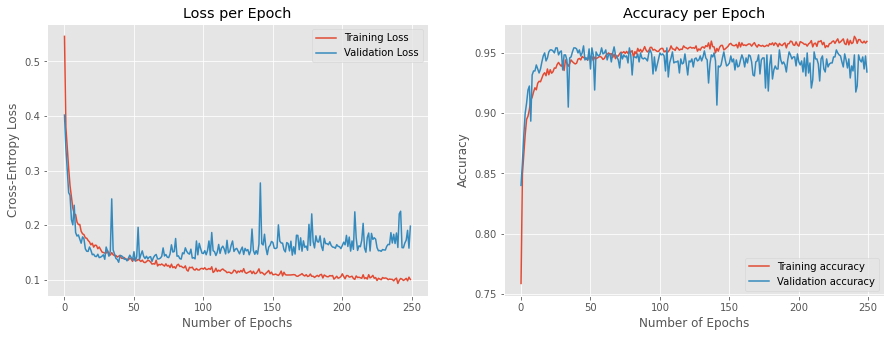

In [82]:
plt.subplots(figsize=(15,5))

plt.subplot(121)
plt.plot(history.history['loss'],label = 'Training Loss')
plt.plot(history.history['val_loss'],label = 'Validation Loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.title('Loss per Epoch')
plt.legend()

plt.subplot(122)
plt.plot(history.history['accuracy'],label = 'Training accuracy')
plt.plot(history.history['val_accuracy'],label = 'Validation accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()

plt.show()

In [83]:
yy_test = pd.get_dummies(yy)
results = model.evaluate(xx_dummy, yy_test, batch_size=128)
#y_hat = model.predict_classes(xx_dummy, verbose=1)
#y_hat_dummy = pd.get_dummies(y_hat)
print("test loss, test acc:", results)
#print(sklearn.metrics.f1_score(y_hat_dummy, yy_test,average='micro'))

47/47 [==============================] - 0s 1ms/step - loss: 0.2645 - accuracy: 0.9265
test loss, test acc: [0.2645142674446106, 0.9265000224113464]


In [84]:
svm_y = np.empty((len(features),1))

for i in range(len(features)):
    if features.iloc[i] == 1:
        svm_y[i] = 1
    else:
        svm_y[i] = -1

svm_y.astype(int)
x_train, x_test, y_train, y_test = train_test_split(x_wd,svm_y, test_size = 0.2, shuffle=True)


clf = svm.SVC(kernel='rbf')
clf.fit(x_train, y_train)
print(clf.score(x_train, y_train))
print(clf.score(x_test, y_test))

/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.9441666666666667
0.9241666666666667


In [85]:
svm_y_test = np.empty((len(yy),1))

for i in range(len(yy)):
    if yy.iloc[i] == 1:
        svm_y_test[i] = 1
    else:
        svm_y_test[i] = -1

In [86]:
y_pred = clf.predict(xx_dummy)
print(clf.score(xx_dummy, svm_y_test))
print(sklearn.metrics.f1_score(y_pred, svm_y_test,average='micro'))

0.9268333333333333
0.9268333333333332


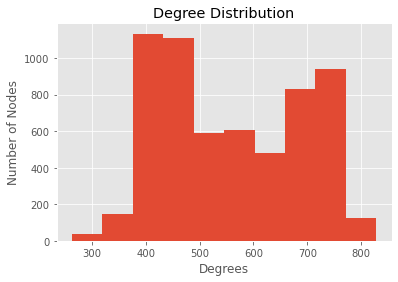

In [87]:
def plot_degree_dist(G):
    degrees = [G.degree(n) for n in G.nodes()]
    plt.hist(degrees)
    plt.title('Degree Distribution')
    plt.xlabel('Degrees')
    plt.ylabel('Number of Nodes')
    plt.show()
    
plot_degree_dist(G)

In [88]:
G.number_of_edges()

1678903

In [89]:
clf = RandomForestClassifier(max_depth=None, random_state=0)

x_train, x_test, y_train, y_test = train_test_split(x_wd,svm_y, test_size = 0.2, shuffle=True)

clf.fit(x_train, y_train)
print(clf.score(x_train, y_train))
print(clf.score(x_test, y_test))

<ipython-input-89-ecdc1502b742>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)


1.0
0.9458333333333333


In [90]:
y_pred = clf.predict(xx_dummy)
print(clf.score(xx_dummy, svm_y_test))
print(sklearn.metrics.f1_score(y_pred, svm_y_test))

0.9436666666666667
0.9337514700117601


In [91]:
clf = AdaBoostClassifier(n_estimators=100, random_state=0)
clf.fit(x_train, y_train)
y_pred = clf.predict(xx_dummy)
print(clf.score(x_train, y_train))
print(clf.score(x_test, y_test))
print(clf.score(xx_dummy, svm_y_test))
print(sklearn.metrics.f1_score(y_pred, svm_y_test))

/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.9383333333333334
0.9183333333333333
0.9275
0.9147226034110958


In [92]:
clf = GaussianNB()
clf.fit(x_train, y_train)
y_pred = clf.predict(xx_dummy)
print(clf.score(x_train, y_train))
print(clf.score(x_test, y_test))
print(clf.score(xx_dummy, svm_y_test))
print(sklearn.metrics.f1_score(y_pred, svm_y_test))

0.874375
0.8608333333333333
0.8596666666666667
0.8348371910553158


/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [93]:
clf = QDA()
clf.fit(x_train, y_train)
print(clf.score(x_train, y_train))
print(clf.score(x_test, y_test))
print(clf.score(xx_dummy, svm_y_test))

0.7708333333333334
0.7508333333333334
0.7458333333333333


/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [94]:
x_train, x_test, y_train, y_test = train_test_split(x_wd,features, test_size = 0.2, shuffle=True)
clf = LogisticRegression(random_state=0,max_iter=500).fit(x_train, y_train)
y_pred = clf.predict(xx_dummy)
print(clf.score(x_train, y_train))
print(clf.score(x_test, y_test))
print(clf.score(xx_dummy, yy))
print(sklearn.metrics.f1_score(y_pred, yy))

0.885625
0.8658333333333333
0.8685
0.8459285295840655
